In [2]:

import pandas as pd
import numpy as np
#from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, matrix_normal, invwishart
#import networkx as nx
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')

#import DyGraph as dg
#import CovReg as cr
import matplotlib.pyplot as plt
#import tqdm
#import scipy
from scipy.optimize import minimize
#from sklearn import linear_model

from sklearn.metrics.pairwise import rbf_kernel, linear_kernel


In [2]:
def lasso_objective(param, X, Y,Psi_inv, d,r, alpha, a = None)->tuple:
    """"
    Objective and gradient to pass into the L-BFGS-B solver to solve the lasso problem.
    """
    if a is not None:
        C = np.hstack((a, np.reshape(param[:r*d]-param[r*d:],(d,r))))
    else:
        C = np.reshape(param[:r*d]-param[r*d:],(d,r))
    
    obj =  np.trace(np.dot((Y- np.dot(X,C.T)).T,(Y- np.dot(X,C.T))).dot(Psi_inv)) + alpha*param.sum()
    t_0 = Y.T-np.dot(C,X.T)
    if a is None:
        grad = (-0.5*np.dot(t_0,X)).flatten()
    else:
        grad = (-0.5*np.dot(t_0,X)).flatten()[:d*r]
    return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None)




In [2]:
n = 1000
d = 3
r = 3
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
#B_true =B_true*(np.random.uniform(size = (d,r) ) <0.3)


Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon


Y_tilde = np.vstack((Y, np.zeros((n,d))))
#print(np.round(B_true,2))
#print("\n")


# MCMC for cov regression

In [5]:
B = 1000


B_est = np.zeros((B+1, d,r))
B_est[0] = np.random.normal(loc = 0, scale = 1, size = (d,r))

Psi_est = np.zeros((B+1, d,d))
Psi_est[0] = np.identity(d)

V0 = np.identity(r)
C0 = np.zeros((d,r))
phi0 = np.identity(d)

for b in tqdm.tqdm(range(B)):
    psi_inv = np.linalg.inv(Psi_est[b])
    g = np.zeros(n)
    for i in range(n):
        v = 1/(1+np.dot(X[i], B_est[b].T).dot(psi_inv).dot(B_est[b]).dot(X[i]))
        m = v*np.dot(X[i], psi_inv).dot( B_est[b]).dot(Y[i])
        g[i] = np.random.normal(loc = m, scale = np.sqrt(v))

    Xg = np.dot(np.diag(g),X)

    V0_inv = np.linalg.inv(V0)
    inv_matrix = np.linalg.inv(np.dot(Xg.T, Xg) + V0_inv)
    C_n = np.dot(np.dot(Y.T,Xg) + np.dot(C0, V0_inv),inv_matrix)
    yy = Y - np.dot(Xg, C_n.T)
    Phi_n = phi0 + np.dot(yy.T, yy) + np.dot((C_n-C0).T, V0_inv).dot(C_n-C0)

    Psi_est[b+1] = invwishart.rvs(df = 5 + n, scale =  np.linalg.inv(Phi_n))

    B_est[b+1] = matrix_normal.rvs(mean=C_n, rowcov=Psi_est[b+1], colcov=inv_matrix)





100%|██████████| 1000/1000 [00:02<00:00, 356.20it/s]


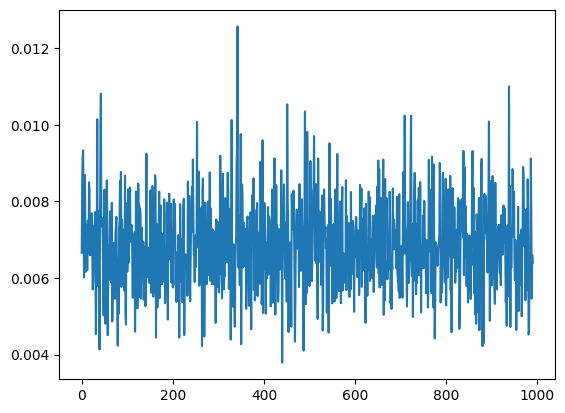

In [6]:
plt.plot(B_est[10:,0,0])

In [13]:
np.mean(B_est,0)

array([0.18295064, 1.325767  , 1.38505909])

MCMC EM

In [55]:
B_est = np.ones((d,r))
Psi_est = np.identity(d)
Y_tilde = np.vstack((Y, np.zeros((n,d))))
B = 100
g = np.zeros((B,n))
alpha = 0.05

for it in range(10):
    #print(it)
    for b in range(B):
        psi_inv = np.linalg.inv(Psi_est)
        v = np.zeros(n)
        m = np.zeros(n)
        for i in range(n):
            v[i] = 1/(1+np.dot(X[i], B_est.T).dot(psi_inv).dot(B_est).dot(X[i]))
            m[i] = v[i]*np.dot(X[i], psi_inv).dot( B_est).dot(Y[i])
            g[b,i] = np.random.normal(loc = m[i], scale = np.sqrt(v[i]))


    m = np.mean(g, 0)
    v = np.std(g, 0) **2

    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    
    # C_tmp = B_est.flatten()
    # C_vec = np.zeros(2*r*d)
    # C_vec[:r*d] = np.abs(C_tmp) * (C_tmp>0)
    # C_vec[r*d:] = np.abs(C_tmp) * (C_tmp<0)

    # out = minimize(lasso_objective, C_vec, args = (X_tilde, Y_tilde, np.identity(d), d,r, n*alpha, None), method='L-BFGS-B', jac=True, bounds = [(0,None)]*(2*r*d))
    # B_est = out.x
    # B_est = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))


    B_est = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde) + 0.0000001*np.identity(r)))
    #Psi_est = np.cov((Y_tilde-np.dot(X_tilde,B_est.T)).T)*(n-1)/n

    

In [56]:
B_est

array([[-1.12534051, -0.36989387, -1.09699673],
       [ 1.63252505,  0.75725218,  1.51286914],
       [-0.14399432,  0.03131733, -0.09693329]])

In [57]:
B_true

array([[-1.25030908,  0.04827532, -1.35981979],
       [ 2.17204515,  0.56480767,  1.75845894],
       [-0.15393804,  0.1560561 ,  0.21598115]])

# MCMC one latent f

In [11]:
n = 100
d = 1
r = 1
scale = 0.1

T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 0.1) + 0.001*np.identity(n)# linear_kernel(T,T)+ 0.001*np.identity(n)# rbf_kernel(T,T, gamma = 0.1) + 0.001*np.identity(n)

rnd = np.random.RandomState(42)
f_true = rnd.multivariate_normal(mean = np.zeros(n), cov = K)
f_true = f_true.reshape(-1,1)



gamma = rnd.normal(loc = 0, scale = 1, size = (n))
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
#B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
#A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
P = rnd.binomial(1,0.5,size = (d,r) )
A_true = rnd.uniform(-1,1,size = (d,r))
A_true[A_true <0.5] = 0
B_true = rnd.uniform(-1,1,size = (d,r))
B_true[np.abs(B_true)<0.3] = 0#*(np.random.uniform(size = (d,r) ) <0.5)
A_true = A_true*(rnd.uniform(size = (d,r) ) <0.5)

# Y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon
Y =gamma[:, np.newaxis]*f_true + epsilon


In [12]:
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

In [13]:

with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    gamma = pm.Normal("sigma", 0, sigma=1)

    cov = pm.gp.cov.ExpQuad(1, np.sqrt(1/(2*0.1))) +pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=T)
    
    # Define likelihood
    likelihood = pm.Normal("y", mu= f*gamma, sigma=scale, observed=Y[:,0])
    #likelihood = pm.Normal("y", mu= f, sigma=scale, observed=Y[:,0])

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(5000, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, f_rotated_]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 365 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1734 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
f_post = az.extract(trace, var_names="f").transpose("sample", ...)

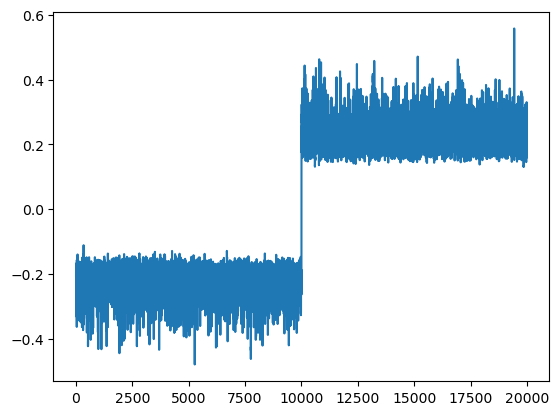

In [29]:
plt.plot(f_post[:,0])

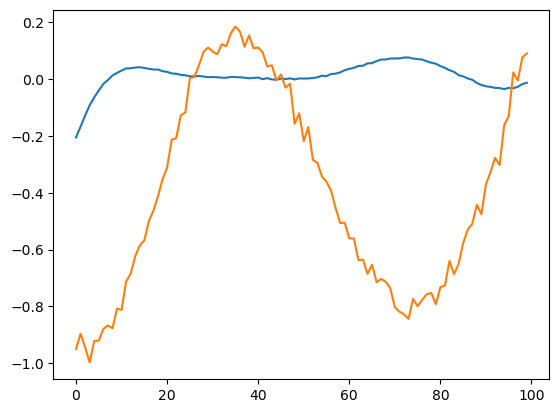

In [31]:
fig, ax = plt.subplots(1,1)
#ax.plot(np.mean(f_post,0))
ax.plot(f_post[0,:])
ax.plot(f_true)

In [10]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [11]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In [16]:
x.shape

(200,)

In [14]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


In [75]:
B_est = B_true# np.ones((d,r))
Psi_est = np.identity(d)
Y_tilde = np.vstack((Y, np.zeros((n,d))))
B = 100
g = np.ones((B,n))
g[0] = np.random.normal(n)
alpha = 0.05#
index = np.arange(n)
f = np.zeros((B+1,n))
f[0] = np.random.normal(size = n)

psi_inv = np.identity(d)/(scale**2)

rejections = np.ones((B, n))
#for it in range(10):
#print(it)
for b in tqdm.tqdm(range(B)):

    v = np.zeros(n)
    m = np.zeros(n)
    for i in range(n):
        v[i] = 1/(1+np.dot(f[b,i], B_est.T).dot(psi_inv).dot(B_est).dot(f[b,i]))
        m[i] = v[i]*np.dot(f[b,i], psi_inv).dot(B_est).dot(Y[i])
        g[b,i] = np.random.normal(loc = m[i], scale = np.sqrt(v[i]))


    # simulate 
    #f_sample = f[b,:].copy()
    for j in np.array_split(range(n),50):
        index_not_j = index[~np.isin(index,j)]
        K_inv = np.linalg.inv(K[np.ix_(index_not_j,index_not_j)])# + 1e-4*np.identity(len(index_not_j)))  # bottlneck + regularization for condition
        # conditional mean 
        m = np.dot(K[np.ix_(j,index_not_j)],K_inv).dot(f[b, index_not_j])
        # conditional variance
        s = K[np.ix_(j,j)] - np.dot(K[np.ix_(j,index_not_j)],K_inv).dot(K[np.ix_(j,index_not_j)].T)
        # f_new = f_sample.copy()
        f_new = f[b].copy()
        f_new[j] = multivariate_normal.rvs(mean = m, cov = s)

        y_lik_new = -0.5*np.sum((Y[:,0] - B_est[0,0]*g[b]*f_new)**2)/(scale**2)
        y_lik_old = -0.5*np.sum((Y[:,0] - B_est[0,0]*g[b]*f[b])**2)/(scale**2)
        if np.log(np.random.uniform()) <= np.min((y_lik_new - y_lik_old,0)):
            f[b+1,j] = f_new[j]
            #f_sample[j] = f_new[j]
            rejections[b,j] = 0
        else:
            f[b+1,j] = f[b,j]



    # f_new = multivariate_normal.rvs(mean = f[b], cov = K)

    # y_lik_new = -0.5*np.sum((Y[:,0] - B_est[0,0]*g[b]*f_new)**2)
    # y_lik_old = -0.5*np.sum((Y[:,0] -  B_est[0,0]*g[b]*f[b])**2)
    # if np.log(np.random.uniform()) <= np.min((y_lik_new - y_lik_old,0)):
    #     f[b+1] = f_new
    #     rejections[b] = 0
    # else:
    #     f[b+1] = f[b].copy()



100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


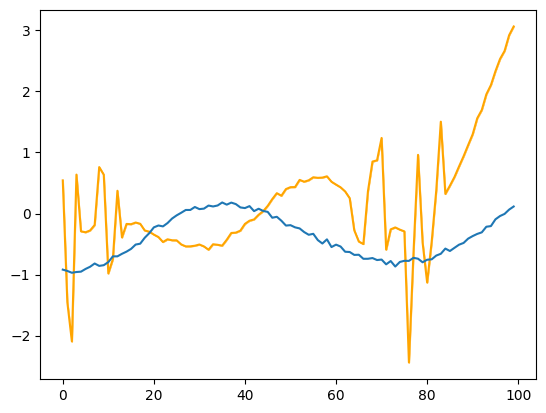

In [78]:
plt.plot(np.mean(f[100:],0), color = 'orange')
plt.fill_between(range(100),np.mean(f[100:],0)-2*np.std(f[100:],0),np.mean(f[100:],0)+2*np.std(f[100:],0), color = 'orange', alpha = 0.4)
plt.plot(f_true)


# MCMC GP

In [3]:
rnd = np.random.RandomState(42)


n = 30
d = 3
r = 3
X = rnd.normal(loc = 0, scale = 1, size = (n,r))
beta = 0.1


G = nx.fast_gnp_random_graph(r, 3/r,    seed = 1)


v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

H = np.array(np.dot(u, np.diag(np.exp(-0.1*v))).dot(u.T))
H_sq = np.dot(H,H)


#T  = np.random.normal(loc = 0, scale = 1, size = (n,r)) 
T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 0.1) + 0.001*np.identity(n)# linear_kernel(T,T)+ 0.001*np.identity(n)# rbf_kernel(T,T, gamma = 0.1) + 0.001*np.identity(n)
# print(K[:,0])

omega = 1
F_true = matrix_normal(rowcov = K, colcov = np.dot(H,H)*(1/omega), seed =1).rvs()

scale = 1
psi = scale*np.identity(d)

gamma = rnd.normal(loc = 0, scale = 1, size = (n))
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
#B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
#A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
P = rnd.binomial(1,0.5,size = (d,r) )
A_true = rnd.uniform(-1,1,size = (d,r))
A_true[A_true <0.5] = 0
B_true = rnd.uniform(-1,1,size = (d,r))
B_true[np.abs(B_true)<0.3] = 0#*(np.random.uniform(size = (d,r) ) <0.5)
A_true = A_true*(rnd.uniform(size = (d,r) ) <0.5)

#Y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon
Y =gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon


NameError: name 'nx' is not defined

In [60]:
B_est = np.ones((d,r))
Psi_est = np.identity(d)
Y_tilde = np.vstack((Y, np.zeros((n,d))))
B = 1000
g = np.zeros((B,n))
Psi_est = psi
F_est = np.zeros((B,n,r))

for it in range(10):
    print(it)
    for b in range(100):
        psi_inv = np.linalg.inv(Psi_est)
        v = np.zeros(n)
        m = np.zeros(n)
        # gamma
        for i in range(n):
            v[i] = 1/(1+np.dot(X[i], B_est.T).dot(psi_inv).dot(B_est).dot(X[i]))
            m[i] = v[i]*np.dot(X[i], psi_inv).dot( B_est).dot(Y[i])
            g[b,i] = np.random.normal(loc = m[i], scale = np.sqrt(v[i]))

        # GP
        index = np.arange(n)
        for j in np.array_split(range(n),5):
            n_j = len(j)
            C = np.kron(K[np.ix_(index_not_j, index_not_j)],H_sq)
            inv_part = np.linalg.inv(C)
            S12 = np.kron(K[np.ix_(j, index_not_j)],H_sq)
            S11 = np.kron(K[np.ix_(j, j)],H_sq)

            mean = np.dot(S12, inv_part).dot(F_est[b,index_not_j,:].flatten(order = 'F'))
            cov = S11 - np.dot(S12,inv_part).dot(S12.T)

            # draw sample
            f_new = np.random.multivariate_normal(mean = mean, cov = cov).reshape((n_j, r), order = 'F')

            new = Y[j] - np.dot(np.diag(g[b,j]), f_new).dot(B_est.T)
            new = -0.5*np.trace(np.dot(psi_inv, new.T).dot(new)) 
            old = Y[j] - np.dot(np.diag(g[b,j]), F_est[b,j]).dot(B_est.T)
            old = -0.5*np.trace(np.dot(psi_inv, old.T).dot(old)) 

            if np.log(np.random.uniform()) <= np.min((new - old,0)):
                F_est[b, j,:] = f_new.copy()



    B_est = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde) + 0.0000001*np.identity(r)))
    #Psi_est = np.cov((Y_tilde-np.dot(X_tilde,B_est.T)).T)*(n-1)/n

    

0
1
2
3
4
5
6


KeyboardInterrupt: 

Running on PyMC v5.8.0


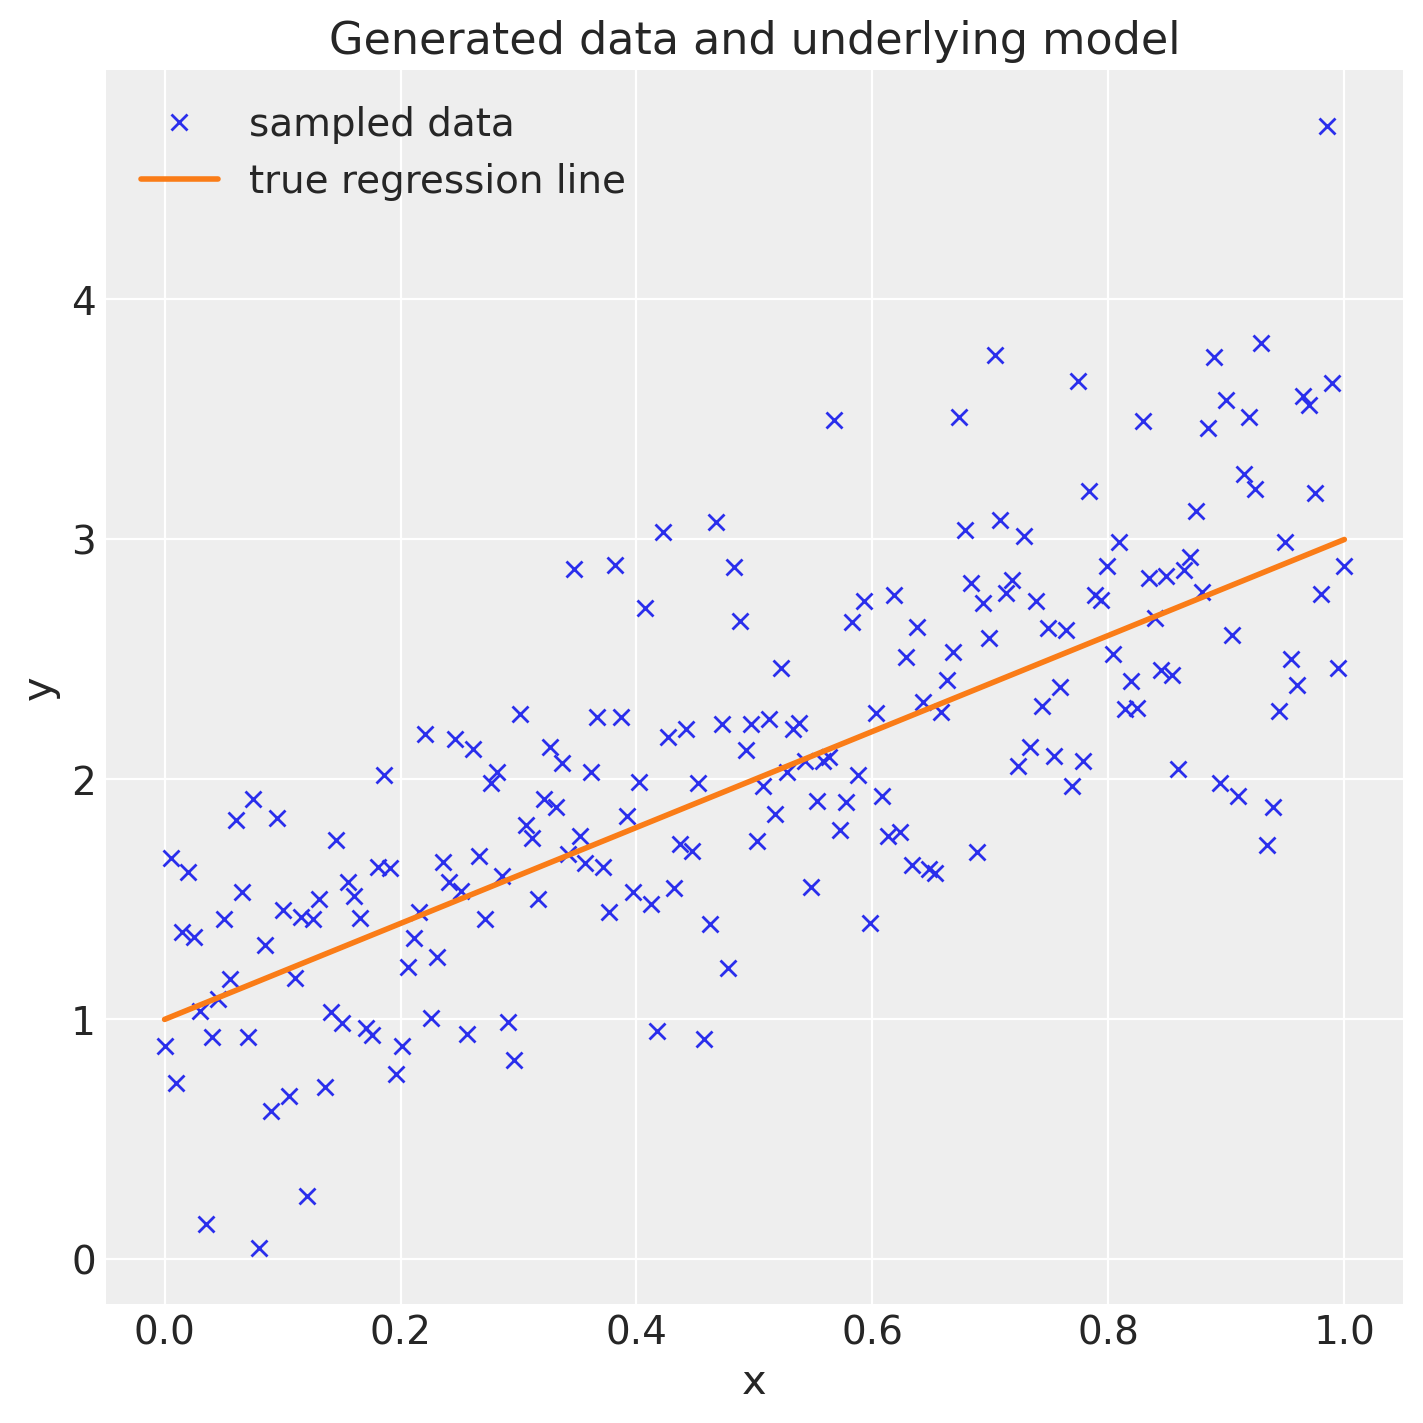

In [40]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")



RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [41]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 43 seconds.
